## Interactive test

raycasting.py does not only contain the base functions to run the raycasting, but is itself executable
- here we run the small interactive example to showcase the raycasting
- exit by pressing ESC
- at start, numba needs to compile some code to make it faster, this takes a moment

You may notice that self-occlusions and occlusions work a bit differently:  
Occlusions can split the visible segment of the occluded object (e.g. the small triangle the weird shape), 
whereas self-occlusions still result in one visible segment (e.g. the weird shape occluding itself). 
However, this does not change the observed angular area, as the connecting segment in the self-occlusion case is parallel to the ray casting from the observer.

The raycasting was adapted from https://ncase.me/sight-and-light/ (and uses numba compiled code to run a bit faster).

In [ ]:
%run raycasting.py

## and now to the fish:

all functions to utilize the raycasting to estimate the visual fields of fish (or any other contours with eyes) can be found in visualfield.py

In [1]:
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import ListedColormap, Normalize
import numpy as np

sys.path.append('/home/paul/Documents/multiviewtracks/MultiViewTracks/')
# download at https://github.com/pnuehrenberg/multiviewtracks and edit path accordingly

from tracks import tracks_to_pooled
from utils import load, save

from visualfield import get_visual_field, contour_from_pose
from raycasting import unit_vector, parallel

In [2]:
# import tracks

tracks = load('../../data/tracks/revised/tracks_T3_revised.pkl')

In [3]:
# run fish test, leave by pressing ESC, select fish with left click (wait on first click, functions being compiled)
# although we model the visual field as binocular, all visible segments from both eyes get concatenated
# here, for simplicity, they get treated as monocular, observed from the average eye position
# (this still accounts for accurate occlusions and self-occlusions)

data_segments, data_ids, data_visual_field, data_position = get_visual_field(tracks)

In [4]:
mpl.rcParams['figure.dpi'] = 100

%matplotlib inline

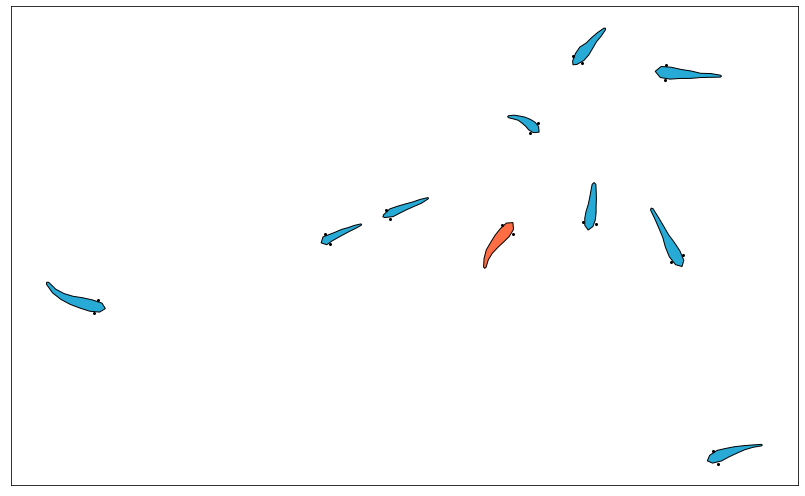

In [13]:
# here, we visualize the contours and eye position of the fish
# color by dom (focal_id) and sub and additionally, we can stipple the fish areas (for figure 2)

mpl.rcParams['hatch.linewidth'] = 1.0  # bigger hatch line width for stippled contours

dom_color = tuple(v / 255 for v in (255, 109, 69))
sub_color = tuple(v / 255 for v in (39, 170, 214))

# get the visual field data
frame = 750
focal_id = 5
data_segments, data_ids, data_visual_field, data_position = get_visual_field(tracks, [frame], focal_id, visualize=False)
        
fig, ax = plt.subplots(figsize=(20, 7))

pooled = tracks_to_pooled(tracks)

for i in pooled['IDENTITY'][pooled['FRAME_IDX'] == frame]:
    
    if not frame in tracks[str(i)]['FRAME_IDX']:
        continue

    spine = tracks[str(i)]['SPINE'][tracks[str(i)]['FRAME_IDX'] == frame].reshape(-1, 2)
    rad = tracks[str(i)]['RADII'][tracks[str(i)]['FRAME_IDX'] == frame].reshape(-1)

    contour, eyes = contour_from_pose(spine, rad)

    plt.fill([pt[0] for pt in contour], [pt[1] for pt in contour],
             facecolor=dom_color if i == focal_id else sub_color,
             edgecolor='k') # hatch='ooo' # for stippled fish

    plt.plot(eyes[:, 0], eyes[:, 1], 'ko', ms=2)

ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])

fig.tight_layout()

plt.show()

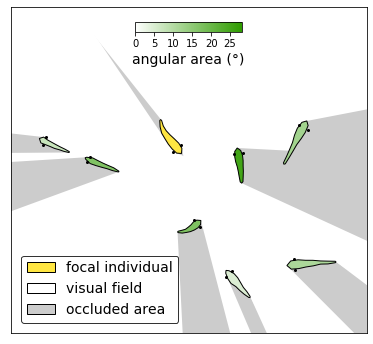

In [14]:
# and extended, we plot the contours, eyes and the visual field of the focal indiviudal

# get the visual field data
frame = 750
focal_id = 5
data_segments, data_ids, data_visual_field, data_position = get_visual_field(tracks, [frame], focal_id, visualize=False)

focal_color = tuple(v / 255 for v in (255, 230, 66))
aa_color = tuple(v / 255 for v in (47, 156, 0))

# the index of the focal id (not necessarily the same as the id)
u = np.argwhere(tracks['IDENTITIES'] == focal_id).ravel()[0]

# initialize and populate the visual connectivity matrix of this frame
angular_areas = np.zeros((tracks['IDENTITIES'].size, tracks['IDENTITIES'].size))
for segments, segments_ids, pos in zip(data_segments, data_ids, data_position):
    if pos is None:
        continue # in case the focal fish is not detected in this frame (will probably raise errors in plotting)
    for segment, segment_id in zip(segments, segments_ids):
        segment = np.array(segment)
        if segment.size == 0:
            continue # not a visible segment (this can't really happen, e.g. only when there are no other contours)
        i = int(segment_id[0])
        v = np.argwhere(tracks['IDENTITIES'] == i).ravel()[0] # the index of the visible fish
        segment_start = unit_vector(segment[0] - pos)
        segment_end = unit_vector(segment[-1] - pos)
        if parallel(segment_start, segment_end):
            continue # if segment consists of one point, the angle is 0 (start end end ray are parallel)
        angular_areas[u, v] += np.degrees(np.arccos(np.dot(segment_start, segment_end)))

vmax = angular_areas.max() * 1.1
angular_areas /= vmax # normalize angular area to color range
        
fig, ax = plt.subplots(figsize=(20, 6))

pooled = tracks_to_pooled(tracks)

# plot as above, only now with different color
for i in pooled['IDENTITY'][pooled['FRAME_IDX'] == frame]:
    
    v = np.argwhere(tracks['IDENTITIES'] == i).ravel()[0]

    if not frame in tracks[str(i)]['FRAME_IDX']:
        continue

    spine = tracks[str(i)]['SPINE'][tracks[str(i)]['FRAME_IDX'] == frame].reshape(-1, 2)
    rad = tracks[str(i)]['RADII'][tracks[str(i)]['FRAME_IDX'] == frame].reshape(-1)

    contour, eyes = contour_from_pose(spine, rad)
    
    # white background first, since angular area is represented with alpha
    plt.fill([pt[0] for pt in contour], [pt[1] for pt in contour], facecolor='w', lw=0)
    plt.fill([pt[0] for pt in contour], [pt[1] for pt in contour],
             facecolor=focal_color if i == focal_id else (*aa_color, angular_areas[u, v]),
             edgecolor='k')

    plt.plot(eyes[:, 0], eyes[:, 1], 'ko', ms=2)

# gray plot background
ax.set_facecolor((0.8, 0.8, 0.8))

# and white, filled contour for the visual field of the focal individual
for idx, contour in enumerate(data_visual_field[0]):
    contour = contour[0]
    contour = np.array(contour).reshape(-1, 2)
    ax.fill(contour[:, 0], contour[:, 1], c='w', lw=0, zorder=0)

ax.set_ylim((720, 170))
ax.set_xlim((580, 1180))
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])

# then, produce colormap and colorbar, add legend
cax = inset_axes(ax, width='30%', height='3%', loc='upper center', borderpad=1.5)

N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(1, aa_color[0], N)
vals[:, 1] = np.linspace(1, aa_color[1], N)
vals[:, 2] = np.linspace(1, aa_color[2], N)
cmap = ListedColormap(vals)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=Normalize(vmin=0, vmax=vmax))
sm.set_array([])

cb = plt.colorbar(sm, cax=cax, orientation='horizontal')

costum_items = [Polygon([[0, 1], [0, 1]], facecolor=focal_color, edgecolor='k', lw=1),
                Polygon([[0, 1], [0, 1]], facecolor='w', edgecolor='k', lw=1),
                Polygon([[0, 1], [0, 1]], facecolor=(0.8, 0.8, 0.8), edgecolor='k', lw=1)]



ax.legend(costum_items, ['focal individual', 'visual field', 'occluded area'], fontsize=14, loc='lower left', edgecolor='k', fancybox=True, borderaxespad=0.75)

cax.set_xlim((0, vmax))
cb.set_ticks(np.arange(0, vmax, 5))
cb.set_ticklabels(np.arange(0, vmax, 5).astype(np.int))
cb.set_label('angular area (°)', fontsize=14)

plt.show()

# Calculate visual field for all trials and all individuals

In [ ]:
# from multiprocessing import Pool

# # here, we run the visual field reconstruction for every individual of each trial, this takes long and creates a lot of data
# # the multiprocessing likely does not work under windows

# # path to tracks, dom id, bottom length of tank in px, video fps
# trials = [('../../data/tracks/revised/tracks_T3_revised.pkl', 0, 1102, 25),
#           ('../../data/tracks/revised/tracks_T4_revised.pkl', 8, 1095, 25),
#           ('../../data/tracks/revised/tracks_T5_revised.pkl', 0, 1106, 25),
#           ('../../data/tracks/revised/tracks_T6_revised.pkl', 7, 1109, 25),
#           ('../../data/tracks/revised/tracks_T7_revised.pkl', 7, 1087, 25),
#           ('../../data/tracks/revised/tracks_T12_revised.pkl', 9, 829, 60)]

# # generate a list of tuples (per trial) to iterate all individuals in all trials
# process_list = [([load(trial[0])] * len(load(trial[0])['IDENTITIES']), # tracks
#                  [None] * len(load(trial[0])['IDENTITIES']), # all frames
#                  load(trial[0])['IDENTITIES'].tolist(), # all identities
#                  [False] * len(load(trial[0])['IDENTITIES'])) \ # don't visualize
#                 for trial in trials]
# # concatenate to a list of tuples (all trials)
# process_list = list(zip(*[sum([process_list[trial][idx] \
#                                for trial in range(len(trials))], []) \
#                           for idx in range(len(process_list[0]))]))

# # run visual field reconstruction
# with Pool(processes=8) as pool:
#     result_list = pool.starmap(run, process_list)
#     pool.close()
#     pool.join()
    
# save(result_list, 'results_all.pkl') # we ran this per trial to make it more manageable and can share the raw results on request

In [ ]:
# # since we split the processes into chunks (for each trial), we need to put the results together to calculate the per trial visual connectivity matrix

# aa_trials = [] # prepare list that contains the visual connectivity matrices for all trials
# # aa_trials = load('angular_areas.pkl') # or load if already saved

In [ ]:
# # for example, here we would load the tracks for trial 12, and the visual field results (from two parts)

# tracks = load('../../data/tracks/revised/tracks_T12_revised.pkl')
# results = load('results_trial_12_0-4.pkl') + load('results_trial_12_5-9.pkl')

In [ ]:
# angular_areas = np.zeros((tracks['IDENTITIES'].size, tracks['IDENTITIES'].size)) # initialize matrix

# # and fill it
# for u, focal_id in enumerate(tracks['IDENTITIES']):
#     data_segments, data_ids, _, data_position = results[u]
#     for segments, segments_ids, pos in zip(data_segments, data_ids, data_position):
#         if pos is None:
#             continue # in case the focal fish is not detected in this frame
#         for segment, segment_id in zip(segments, segments_ids):
#             segment = np.array(segment)
#             if segment.size == 0:
#                 continue # no visible segments (this probably does not happen or very rarely)
#             i = int(segment_id[0])
#             v = np.argwhere(tracks['IDENTITIES'] == i).ravel()[0]
#             segment_start = unit_vector(segment[0] - pos)
#             segment_end = unit_vector(segment[-1] - pos)
#             if parallel(segment_start, segment_end):
#                 continue # if segment consists of one point, the angle is 0 (start end end ray are parallel)
#             angular_areas[u, v] += np.degrees(np.arccos(np.dot(segment_start, segment_end)))

In [ ]:
# # since we just summed the angular areas in the above cell (per pair), we need to calculate the mean
# for u, focal_id in enumerate(tracks['IDENTITIES']):
#     for v, i in enumerate(tracks['IDENTITIES']):
#         shared = np.isin(tracks[str(focal_id)]['FRAME_IDX'], tracks[str(i)]['FRAME_IDX']).sum()
#         angular_areas[u, v] /= shared # therefore, we divide it by the total number of shared frames

In [ ]:
# # append it to the results list and save

# aa_trials.append(angular_areas)
# save(aa_trials, 'angular_areas.pkl') # complete list with all matrices can be found in '../../data/visualfield/angular_areas_all_trials.pkl'